Nama: Aria Wahyu Wicaksono \
Email: wicaksonoariawahyu@gmail.com \
Username: aria_wahyu_w

# 1. Data Loading

In [1]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [2]:
path = "./Dataset/Timeseries_-6.891_107.609_E5_1kWp_crystSi_14_18deg_-107deg_2015_2020.csv"

Header berada di indeks ke-8, sehingga perlu menambahkan parameter `header=8`

In [3]:
df = pd.read_csv(path, header=8, verbose=0)
df.head()

,time,P,G(i),H_sun,T2m,WS10m,Int
0,20150101:0030,189.3,243.86,24.98,18.29,0.83,0.0
1,20150101:0130,393.37,499.38,38.69,19.89,0.48,0.0
2,20150101:0230,499.48,646.29,52.05,21.34,0.69,0.0
3,20150101:0330,550.3,713.89,64.35,22.65,1.03,0.0
4,20150101:0430,616.42,811.23,72.96,23.60,1.38,0.0


# 2. Exploratory Data Analysis

### 2.1. EDA - Deskripsi Variabel dan Analisis Missing Value

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52615 entries, 0 to 52614
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    52615 non-null  object 
 1   P       52609 non-null  object 
 2   G(i)    52608 non-null  float64
 3   H_sun   52608 non-null  float64
 4   T2m     52608 non-null  float64
 5   WS10m   52608 non-null  float64
 6   Int     52608 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.8+ MB


Terdapat beberapa Null _value_ pada dataset. Berikut adalah deksripsi variabel pada dataset

| Variabel | Deskripsi |
| --- | --- |
| time | Waktu pengambilan data tiap jam |
| P | Daya terukur pada sistem PV (W) |
| G(i) | _Global irradiance_ ($ \frac{W}{m^2} $)|
| H_sun | Ketinggian matahari (derajat)|
| T2m | Temperatur udara pada ketinggian 2m (derajat Celcius)|
| WS10m | Kecepatan angin total pada ketinggian 10m ($ \frac{m}{s}$) |
| Int | Data biner yang menyatakan nilai pada baris telah direkonstruksi |

Pada proyek kali ini, target yang digunakan adalah `P` ( Daya yang terukur pada sistem PV ). Nampak bahwa kolom `Int` hanya merupakan penanda / informasi, sehingga tidak akan digunakan sebagai fitur. Kolom waktu juga tidak digunakan sebagai fitur.

In [5]:
df = df.drop(columns=["Int", "time"])
df[df.isna().any(axis=1)]

,P,G(i),H_sun,T2m,WS10m
52608,NaN,NaN,NaN,NaN,NaN
52609,NaN,NaN,NaN,NaN,NaN
52610,NaN,NaN,NaN,NaN,NaN
52611,NaN,NaN,NaN,NaN,NaN
52612,NaN,NaN,NaN,NaN,NaN
52613,NaN,NaN,NaN,NaN,NaN
52614,2001-2023,NaN,NaN,NaN,NaN


7 baris terakhir ternyata adalah metadata dataset, oleh karena itu baris-baris tersebut di-drop.

In [6]:
df = df.dropna(how="any")
df[df.isna().any(axis=1)]

,P,G(i),H_sun,T2m,WS10m


Data daya `P` masih bertipe `object`

In [7]:
df["P"] = df["P"].astype(np.float64)

In [8]:
df["P"].dtypes

dtype('float64')

### 2.2. Analisis Univariat Distribusi Target (kolom `P`)

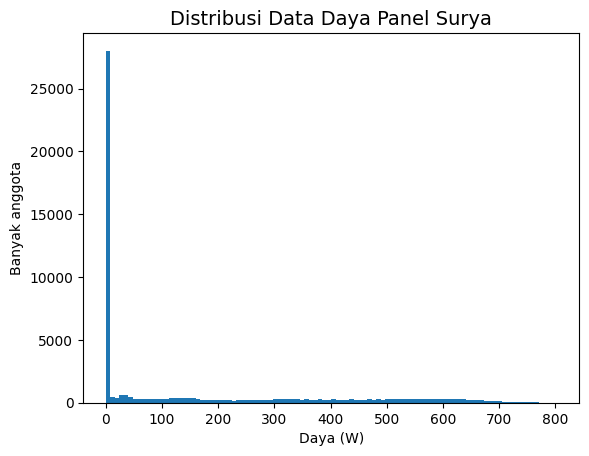

In [9]:
counts, bins = np.histogram(df["P"], bins=100)
plt.hist(df["P"],bins=bins)
plt.title("Distribusi Data Daya Panel Surya", fontsize=14)
plt.xlabel("Daya (W)")
plt.ylabel("Banyak anggota")
plt.show()

In [10]:
print(bins[0:2])
print(df[df["P"] <= 8.0213].shape[0])

[0.     8.0213]
28019


Nampak bahwa data dengan daya di antara 0. hingga 8.0213 memiliki 28019 data. Oleh karena itu, akan dilakukan metode random undersampling

In [11]:
sample_mean = np.mean(counts[1:])
sample_mean = int(sample_mean)

In [12]:
idx = df[(df["P"] >= 0.) & (df["P"] <  8.0213)].index
sample_idx = np.random.choice(idx, len(idx)-sample_mean, replace=False)
df = df.drop(index=sample_idx)
print(df.shape)

(24837, 5)


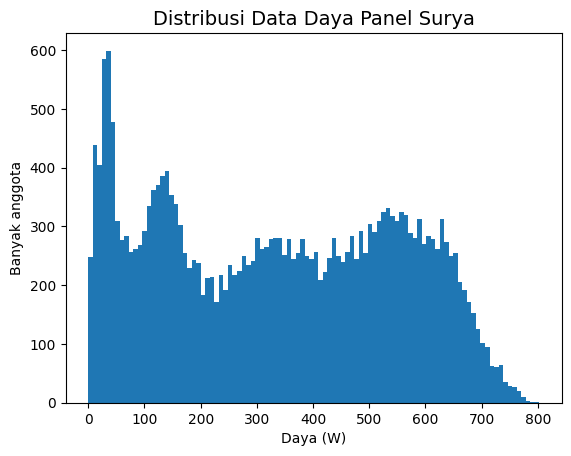

In [13]:
histogram = plt.hist(df["P"], bins=bins)
plt.title("Distribusi Data Daya Panel Surya", fontsize=14)
plt.xlabel("Daya (W)")
plt.ylabel("Banyak anggota")
plt.show()

Distribusi target sudah jauh lebih baik

### 2.3. EDA - Outlier Fitur dan Analisis Multivariat

<Axes: xlabel='G(i)'>

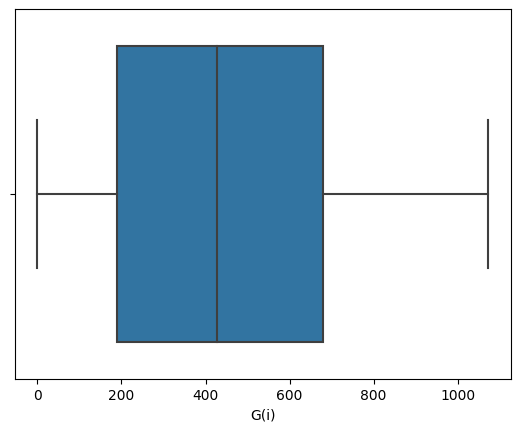

In [14]:
sns.boxplot(x=df["G(i)"])

<Axes: xlabel='H_sun'>

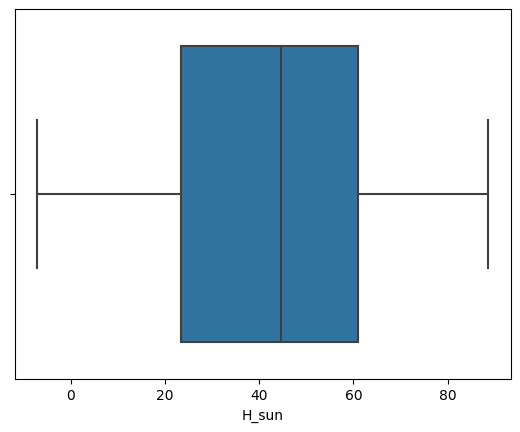

In [15]:
sns.boxplot(x=df["H_sun"])

<Axes: xlabel='T2m'>

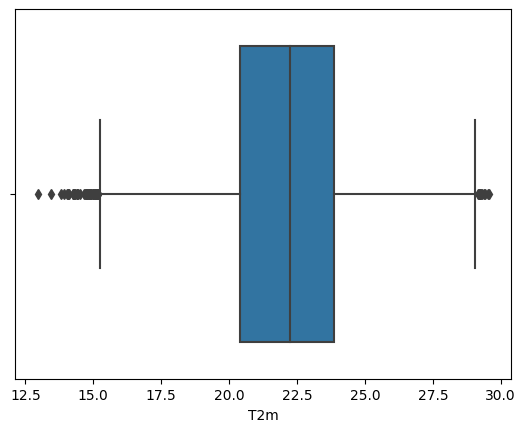

In [16]:
sns.boxplot(x=df["T2m"])

<Axes: xlabel='WS10m'>

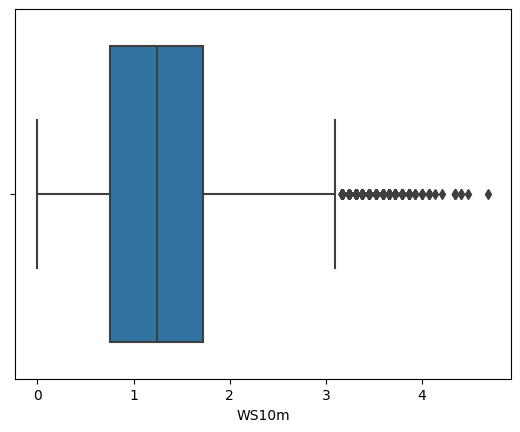

In [17]:
sns.boxplot(x=df["WS10m"])

Shape sebelumnya:

In [18]:
df.shape

(24837, 5)

In [19]:
def detect_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    outlier_rows = series[((series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))).any(axis=1)]
    return outlier_rows.index

rows = detect_outliers(df[['G(i)', 'H_sun', 'T2m', 'WS10m']])
df = df.drop(rows, axis=0)
print("Shape setelah drop outlier: ")
print(df.shape)

Shape setelah drop outlier: 
(24410, 5)


In [20]:
df.corr(numeric_only=True)

,P,G(i),H_sun,T2m,WS10m
P,1.000000,0.998947,0.707279,0.394574,0.066886
G(i),0.998947,1.000000,0.705381,0.411336,0.068219
H_sun,0.707279,0.705381,1.000000,0.618974,0.350782
T2m,0.394574,0.411336,0.618974,1.000000,0.527411
WS10m,0.066886,0.068219,0.350782,0.527411,1.000000


Nampak bahwa hanya fitur G(i) dan H_sun saja yang berkolerasi kuat terhadap target P

# 3. Data Preparation

In [21]:
y = df['P']
x = df[["G(i)", "H_sun"]]

In [22]:
scaler= MinMaxScaler()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=83)
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

In [23]:
x_train_norm.shape, x_test_norm.shape

((19528, 2), (4882, 2))

# 4. Model Development

### 4.1. Model Artificial Neural Network

In [24]:
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(8, input_dim=x_train.shape[1]),
    tf.keras.layers.Dense(16, kernel_regularizer="l2", bias_regularizer="l2", activation="ReLU"),
    tf.keras.layers.Dense(16, kernel_regularizer="l2", bias_regularizer="l2", activation="ReLU"),
    tf.keras.layers.Dense(16, kernel_regularizer="l2", bias_regularizer="l2", activation="ReLU"),
    tf.keras.layers.Dense(1)
])
ann.compile(loss='mse',
            optimizer='adam')
ann.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 16)                144       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 729
Trainable params: 729
Non-trainable params: 0
_________________________________________________________________


In [25]:
history = ann.fit(x_train_norm, y_train,
                validation_data=(x_test_norm, y_test),
                epochs=50,
                verbose=0)

### 4.2. Model Adaboost

In [26]:
adaboost = AdaBoostRegressor(random_state=83, n_estimators=300, learning_rate=0.8)
adaboost.fit(x_train_norm, y_train)

AdaBoostRegressor(learning_rate=0.8, n_estimators=300, random_state=83)

### 4.3 Model Random Forest

In [27]:
rand_forest = RandomForestRegressor(max_depth=12, random_state=83)
rand_forest.fit(x_train_norm, y_train)

RandomForestRegressor(max_depth=12, random_state=83)

### 4.4 Model Non-linear SVR

In [28]:
svr = SVR(kernel="rbf")
svr.fit(x_train_norm, y_train)

SVR()

### 4.5 KNN

In [29]:
knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(x_train_norm, y_train)

KNeighborsRegressor(n_neighbors=8)

# 5. Evaluasi Model

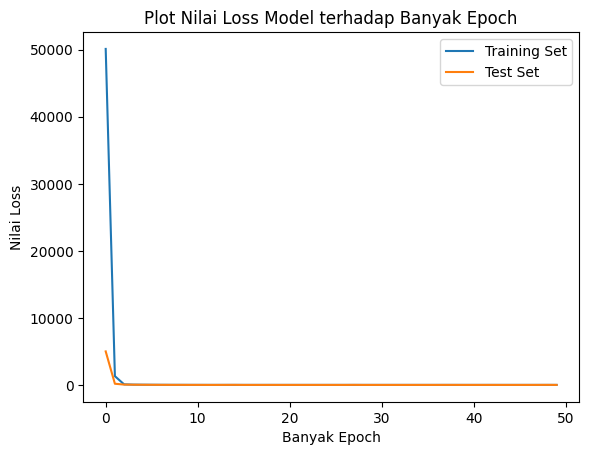

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot Nilai Loss Model terhadap Banyak Epoch')
plt.ylabel('Nilai Loss')
plt.xlabel('Banyak Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.show()

In [31]:
mse = pd.DataFrame(columns=['train', 'test'], index=['ANN', 'Boosting','RF','SVR','KNN'])
sklearn_models = {'Boosting': adaboost,
                  'RF': rand_forest,
                  'SVR': svr,
                  'KNN': knn}
mse.loc['ANN', 'train'] = history.history['loss'][-1]
mse.loc['ANN', 'test'] = history.history['val_loss'][-1]
for name, model in sklearn_models.items():
    mse.loc[name, 'train'] = mean_squared_error(y_pred = model.predict(x_train_norm), y_true=y_train)
    mse.loc[name, 'test'] = mean_squared_error(y_pred = model.predict(x_test_norm), y_true=y_test)

In [32]:
mse

,train,test
ANN,31.730236,30.512764
Boosting,73.943445,76.065942
RF,6.154884,14.350952
SVR,86.019075,89.360662
KNN,12.976992,16.773169


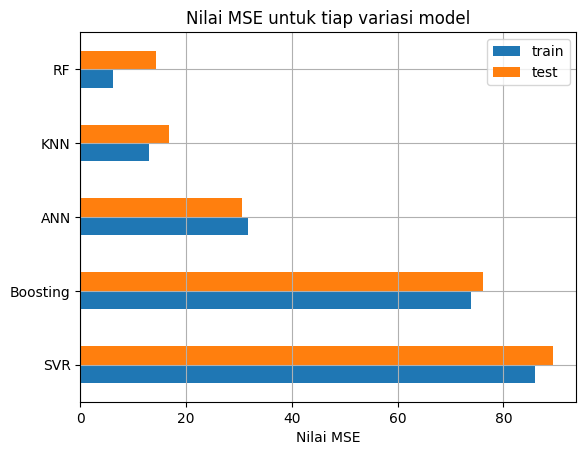

In [33]:
fig, ax = plt.subplots()
ax.set_title("Nilai MSE untuk tiap variasi model")
mse.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax)
ax.set_xlabel("Nilai MSE")
ax.grid(zorder=0)

In [34]:
n_sample = 5
pred_dict = {'y_true':y_test.iloc[:n_sample].values}
x = x_test_norm[:n_sample].reshape(-1,2)
pred_dict['prediksi_ANN'] = ann.predict(x).flatten().astype(float).round(2)
for name, model in sklearn_models.items():
    pred_dict['prediksi_'+name] = model.predict(x).round(2)
pd.DataFrame(pred_dict)

1/1 [==============================] - 0s 341ms/step


,y_true,prediksi_ANN,prediksi_Boosting,prediksi_RF,prediksi_SVR,prediksi_KNN
0,234.15,224.96,219.94,205.87,224.74,207.64
1,399.15,397.14,410.33,396.46,397.59,400.06
2,114.60,117.65,117.97,113.25,115.27,113.36
3,533.25,533.35,536.60,533.73,533.72,533.92
4,159.42,157.60,147.50,159.55,161.23,159.25
